In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Ładowanie danych
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [2]:
# Normalizacja danych
train_images = train_images / 255.0
test_images = test_images / 255.0

In [3]:
# Konwersja etykiet na typ int32
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

In [4]:
# Podział danych na zestaw treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=10, stratify=train_labels)

In [5]:
# Tworzenie zbioru typu Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

In [6]:
import tensorflow.keras.layers as layers

# Definicja modelu z dodatkowymi warstwami i regularizacją
model = tf.keras.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(300, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(10, activation='softmax')
])

C:\Users\Wojciech\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Kompilacja modelu
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [8]:
# Trening modelu
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7731 - loss: 0.6473 - val_accuracy: 0.8548 - val_loss: 0.3955
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8616 - loss: 0.3835 - val_accuracy: 0.8683 - val_loss: 0.3514
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8761 - loss: 0.3391 - val_accuracy: 0.8742 - val_loss: 0.3364
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8841 - loss: 0.3116 - val_accuracy: 0.8812 - val_loss: 0.3241
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8905 - loss: 0.2955 - val_accuracy: 0.8805 - val_loss: 0.3250
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8955 - loss: 0.2789 - val_accuracy: 0.8830 - val_loss: 0.3177
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9004 - loss: 0.2662 - val_accuracy: 0.8878 - val_loss: 0.3009
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9064 - loss: 0.2499 - val_accuracy: 0

In [9]:
# Ocena modelu na zestawie testowym
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8842 - loss: 0.4288
Test accuracy: 0.8828999996185303


In [10]:
import matplotlib.pyplot as plt

# Zapisanie modelu
model.save('fashion_mnist_model.h5')

# Ładowanie modelu
loaded_model = tf.keras.models.load_model('fashion_mnist_model.h5')

In [11]:
def predict_and_display(image, model):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    image = np.expand_dims(image, axis=0)  # Dodanie wymiaru batch
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction)
    print(f'Predicted label: {predicted_label}')

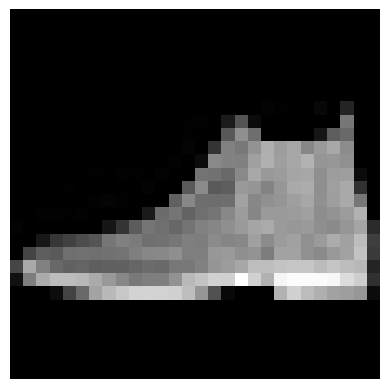

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted label: 9


In [12]:
sample_image = test_images[0]
predict_and_display(sample_image, loaded_model)

In [13]:
!pip install albumentations


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import albumentations as A
from albumentations.core.composition import Compose, OneOf
from albumentations import HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast

# Definiowanie transformacji augmentacyjnych
transform = Compose([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    RandomBrightnessContrast(p=0.2)
])

def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, lbl in zip(images, labels):
        augmented = transform(image=img)
        augmented_images.append(augmented['image'])
        augmented_labels.append(lbl)
    return np.array(augmented_images), np.array(augmented_labels)

In [15]:
# Augmentacja danych treningowych
augmented_X_train, augmented_y_train = augment_images(X_train, y_train)

In [16]:
# Tworzenie zbioru typu Dataset z danych augmentowanych
augmented_train_ds = tf.data.Dataset.from_tensor_slices((augmented_X_train, augmented_y_train)).shuffle(1000).batch(32)

In [17]:
# Ponowne trenowanie modelu na danych augmentowanych
model.fit(augmented_train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7748 - loss: 0.6869 - val_accuracy: 0.8822 - val_loss: 0.3322
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8303 - loss: 0.4408 - val_accuracy: 0.8677 - val_loss: 0.3528
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8440 - loss: 0.4053 - val_accuracy: 0.8842 - val_loss: 0.3194
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8543 - loss: 0.3759 - val_accuracy: 0.8847 - val_loss: 0.3314
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8635 - loss: 0.3544 - val_accuracy: 0.8893 - val_loss: 0.3216
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8711 - loss: 0.3320 - val_accuracy: 0.8813 - val_loss: 0.3664
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8770 - loss: 0.3165 - val_accuracy: 0.8863 - val_loss: 0.3616
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8848 - loss: 0

In [18]:
# Ponowna ocena modelu na zestawie testowym
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy after augmentation: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8815 - loss: 0.5189
Test accuracy after augmentation: 0.8787999749183655


In [ ]:
print("Po kilkudziesięciu próbach")